#Imports

In [1]:
import csv
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#Load Data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv")
test = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv")

#Basic Visualizations (Question 2)

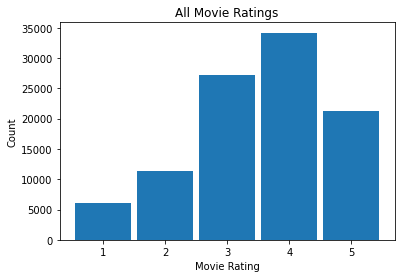

In [3]:
# All ratings in MovieLens Dataset
USER_ID = data["User ID"]
MOVIE_ID = data["Movie ID"]
RATING = data["Rating"]

plt.figure()
plt.hist(RATING,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("All Movie Ratings")
plt.show()

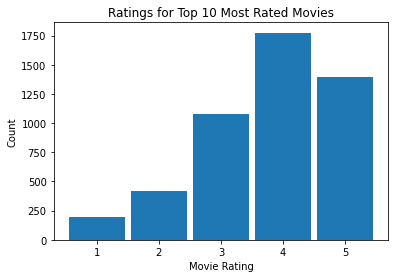

In [4]:
# All rating of the ten most popular movies (movies which have recieved the most ratings)
top10popular = MOVIE_ID.value_counts().nlargest(10).index 
t10pratings = data[data['Movie ID'].isin(top10popular)]['Rating']

plt.figure()
plt.hist(t10pratings,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("Ratings for Top 10 Most Rated Movies")
plt.show()

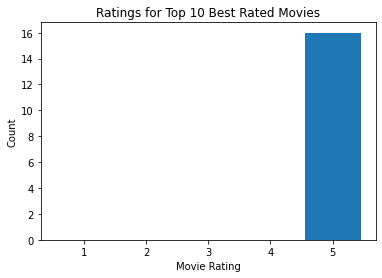

In [5]:
# ALl ratings of the ten best movies (movies with the highest average ratings)
top10best = data.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index
t10bratings = data[data['Movie ID'].isin(top10best)]['Rating']

plt.figure()
plt.hist(t10bratings,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("Ratings for Top 10 Best Rated Movies")
plt.show()

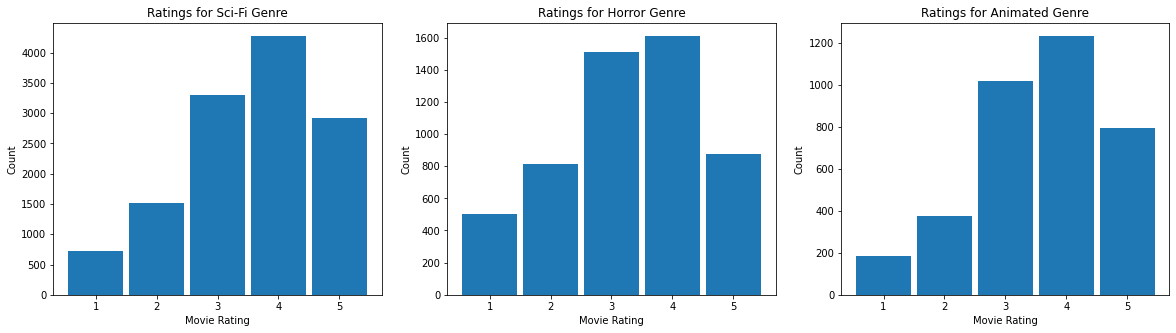

In [6]:
# All ratings of movies from three genres of your choice (three separate visualizations)
scifimovies = movies[movies['Sci-Fi']==1]['Movie ID'] 
scifiratings = data[data['Movie ID'].isin(scifimovies)]['Rating']

horrormovies = movies[movies['Horror']==1]['Movie ID']
horrorratings = data[data['Movie ID'].isin(horrormovies)]['Rating']

animatedmovies = movies[movies['Animation']==1]['Movie ID']
animatedratings = data[data['Movie ID'].isin(animatedmovies)]['Rating']

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(scifiratings,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("Ratings for Sci-Fi Genre")
plt.subplot(1,3,2)
plt.hist(horrorratings,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("Ratings for Horror Genre")
plt.subplot(1,3,3)
plt.hist(animatedratings,bins=[1,2,3,4,5,6],histtype='bar',rwidth=.9,align='left')
plt.xlabel('Movie Rating')
plt.ylabel("Count")
plt.title("Ratings for Animated Genre")
plt.show()

#Matrix Factorization Visualizations (Question 3)

##Without Bias (Question 3 - Method 1)

In [7]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * ((reg * Ui) - (Vj * (Yij - np.dot(Ui, Vj))))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * ((reg * Vj) - (Ui * (Yij - np.dot(Ui, Vj))))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for i in range(len(Y)):
      (i, j, Y_ij) = Y[i]
      err += 0.5 * pow(Y_ij - np.dot(U[i-1], V[j-1]), 2)
    left = (reg/2) * (pow(np.linalg.norm(U),2) + pow(np.linalg.norm(V),2))
    right = err
    return (left + right) / len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(low = -0.5, high = 0.5, size = (M, K))
    V = np.random.uniform(low = -0.5, high = 0.5, size = (N, K))
    MSE_curr = get_err(U, V, Y, reg)
    for k in range(max_epochs):
      np.random.shuffle(Y)
      for i, j, Y_ij in Y:
        U[i - 1] = U[i - 1] - grad_U(U[i - 1], Y_ij, V[j - 1], reg, eta)
        V[j - 1] = V[j - 1] - grad_V(V[j - 1], Y_ij, U[i - 1], reg, eta)
      MSE = get_err(U, V, Y, reg)
      print("Epoch %s: E_in = %s" %(k + 1, MSE))
      if k == 0:
        initial_loss = MSE_curr - MSE
      elif (MSE_curr - MSE)/(initial_loss) <= eps:
        break
      MSE_curr = MSE
    return U, V, MSE_curr

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv")
test = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv")

Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in.append(err)
E_out.append(get_err(U, V, Y_test, reg))
print("E_out = %s" %(E_out[0]))

Factorizing with  943  users,  1682  movies.
Epoch 1: E_in = 0.524250915003379
Epoch 2: E_in = 0.41025666898519964
Epoch 3: E_in = 0.36333375234129794
Epoch 4: E_in = 0.3299961405892663
Epoch 5: E_in = 0.31408496046114126
Epoch 6: E_in = 0.3011008022071551
Epoch 7: E_in = 0.29017067586287454
Epoch 8: E_in = 0.2810819696501579
Epoch 9: E_in = 0.27139863652821167
Epoch 10: E_in = 0.26630076077593484
Epoch 11: E_in = 0.25792310365678867
Epoch 12: E_in = 0.2587813667591773
E_out = 0.6378571006740082


In [9]:
A = np.linalg.svd(V.transpose())[0]
V_tilde = np.dot(A[:, :2].transpose(), V.transpose())
U_tilde = np.dot(A[:, :2].transpose(), U.transpose())

for i in range(len(V_tilde)):
  V_tilde[i] -= np.mean(V_tilde[i])
  V_tilde[i] /= np.std(V_tilde[i])
  U_tilde[i] -= np.mean(V_tilde[i])
  U_tilde[i] /= np.std(V_tilde[i])

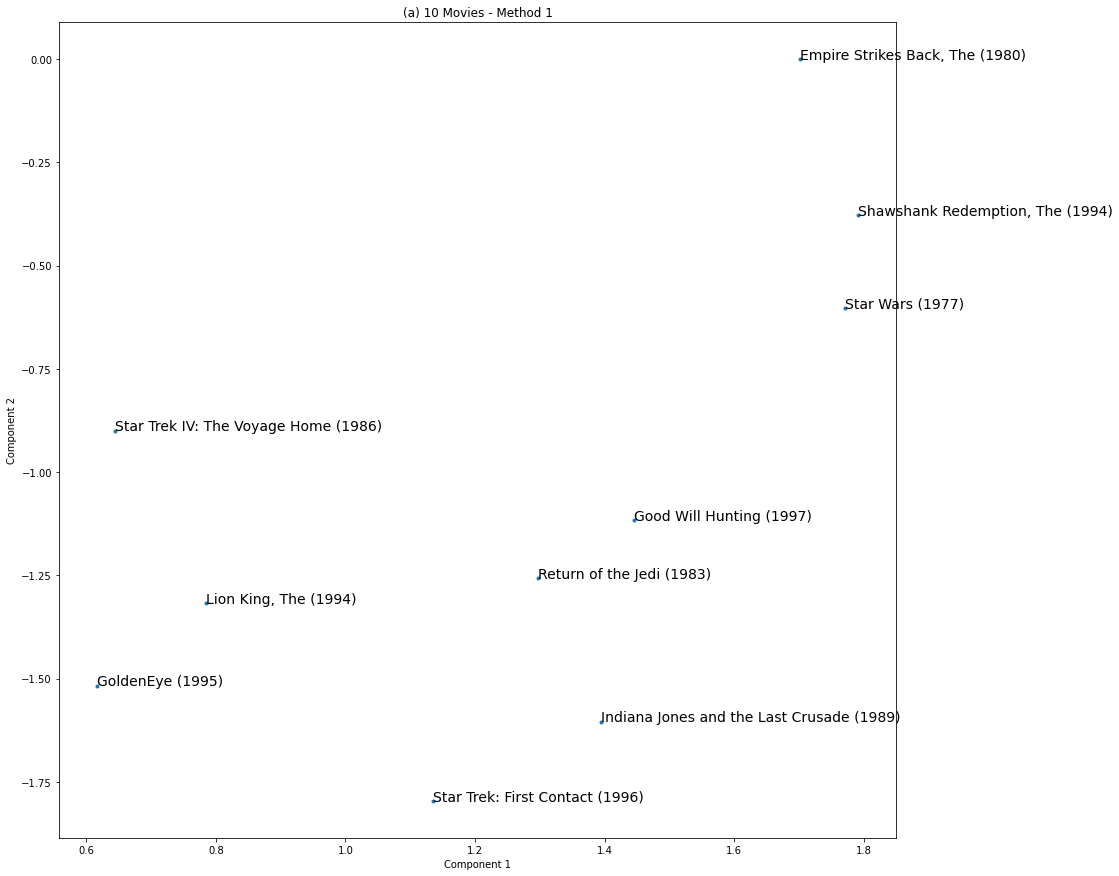

In [10]:
# Any 10 movies of our choice - Method 1
movie_names = np.array(movies)[:,1]
movie_indices = np.array([1, 49, 63, 70, 171, 180, 209, 221, 229, 271])
movie_coordinates = V_tilde[:, movie_indices] 
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("(a) 10 Movies - Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

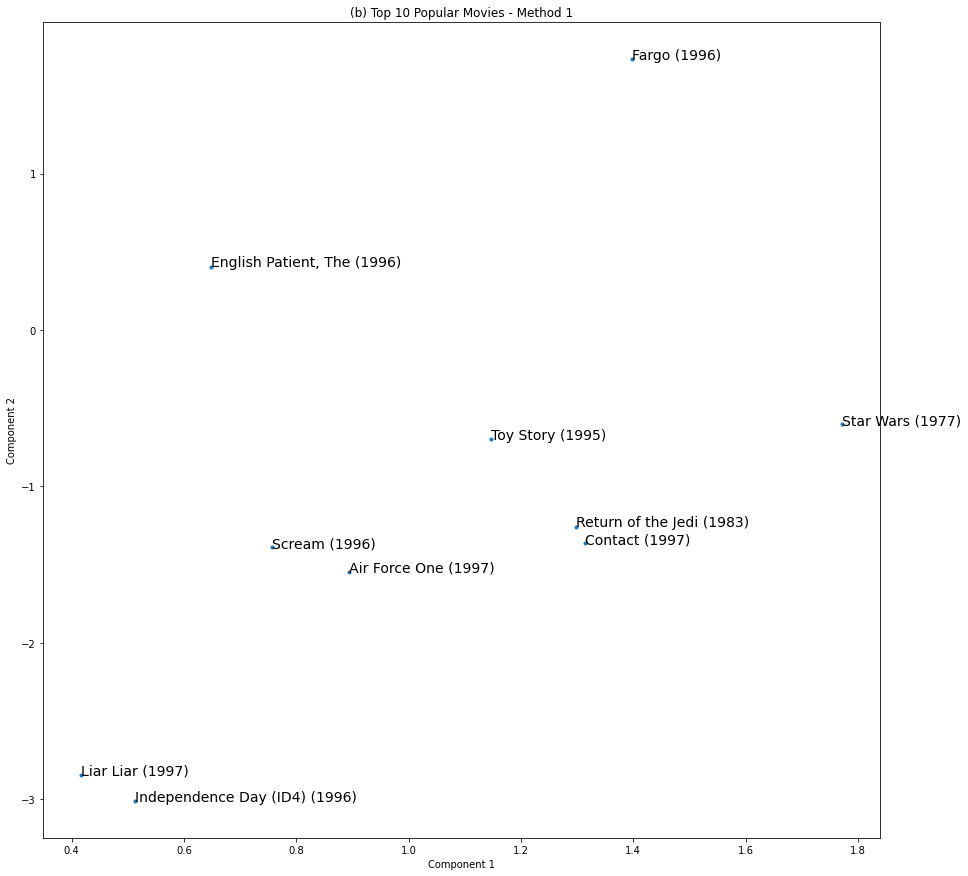

In [11]:
# 10 most popular movies (by most ratings) - Method 1
top10popular = np.array(data["Movie ID"].value_counts().nlargest(10).index)

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10popular]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(b) Top 10 Popular Movies - Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

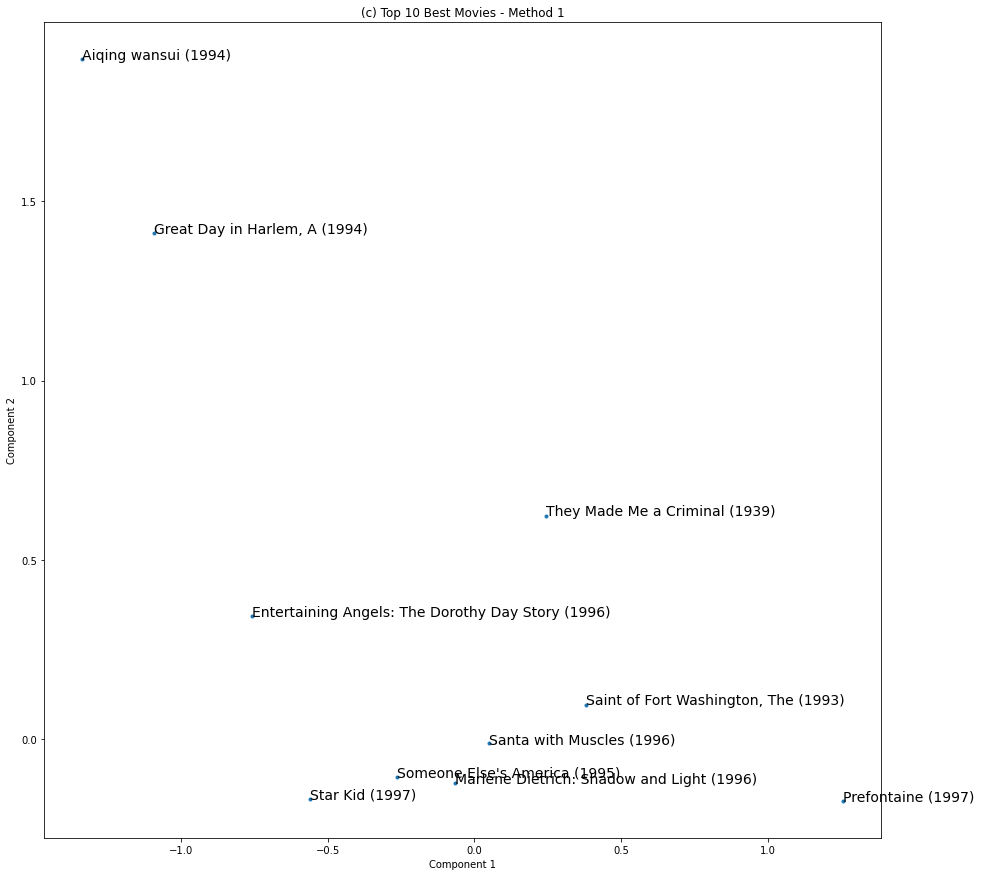

In [12]:
# 10 best movies (by highest average ratings) - Method 1
top10best = data.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10best]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(c) Top 10 Best Movies - Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

In [13]:
scifimovies = np.array(movies[movies['Sci-Fi']==1]['Movie ID'])
scifimovies = scifimovies[random.sample(range(0, len(scifimovies)), 10)]

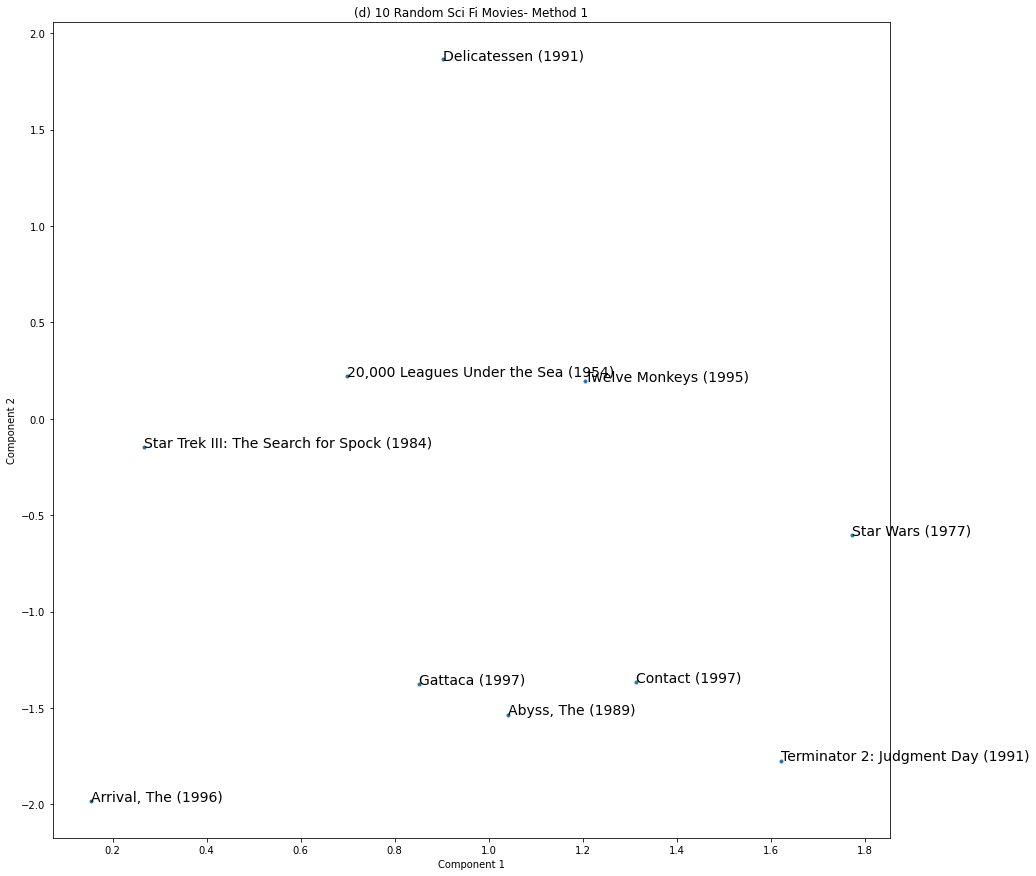

In [14]:
# 10 Random Sci Movies - Method 1
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in scifimovies]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Sci Fi Movies- Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

In [15]:
horrormovies = np.array(movies[movies['Horror']==1]['Movie ID'])
horrormovies = horrormovies[random.sample(range(0, len(horrormovies)), 10)]

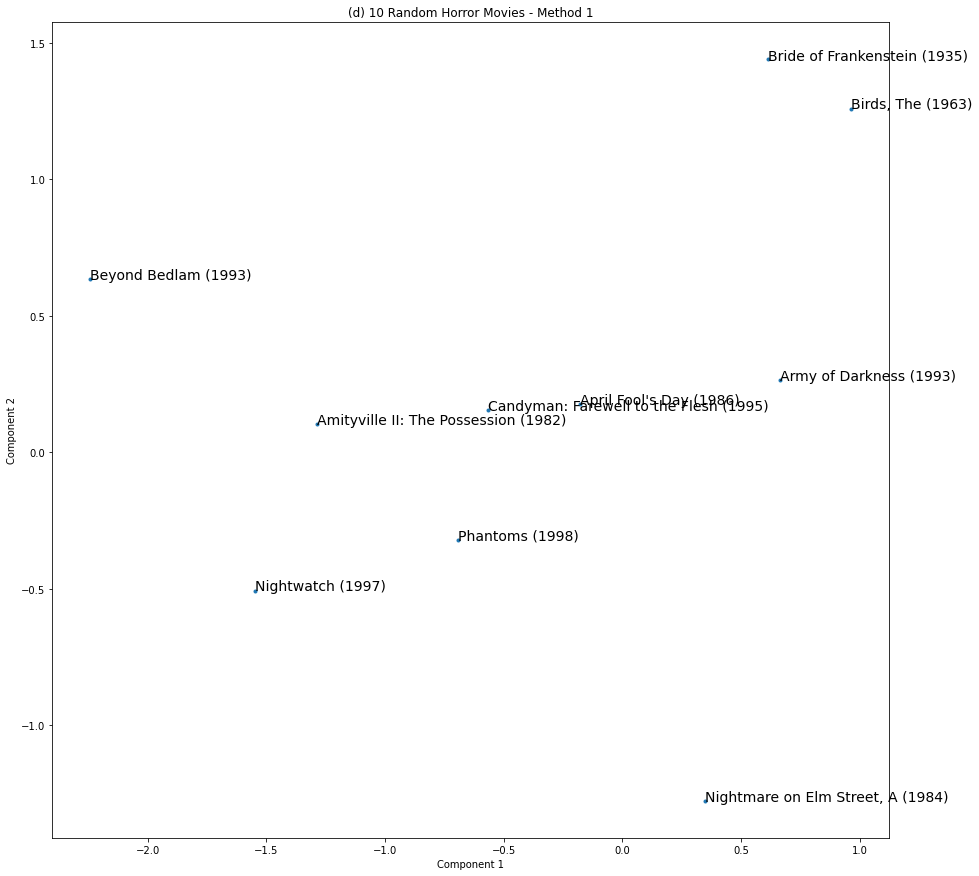

In [16]:
# 10 Random Horror Movies - Method 1
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in horrormovies]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Horror Movies - Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

In [17]:
animatedmovies = np.array(movies[movies['Animation']==1]['Movie ID'])
animatedmovies = animatedmovies[random.sample(range(0, len(animatedmovies)), 10)]

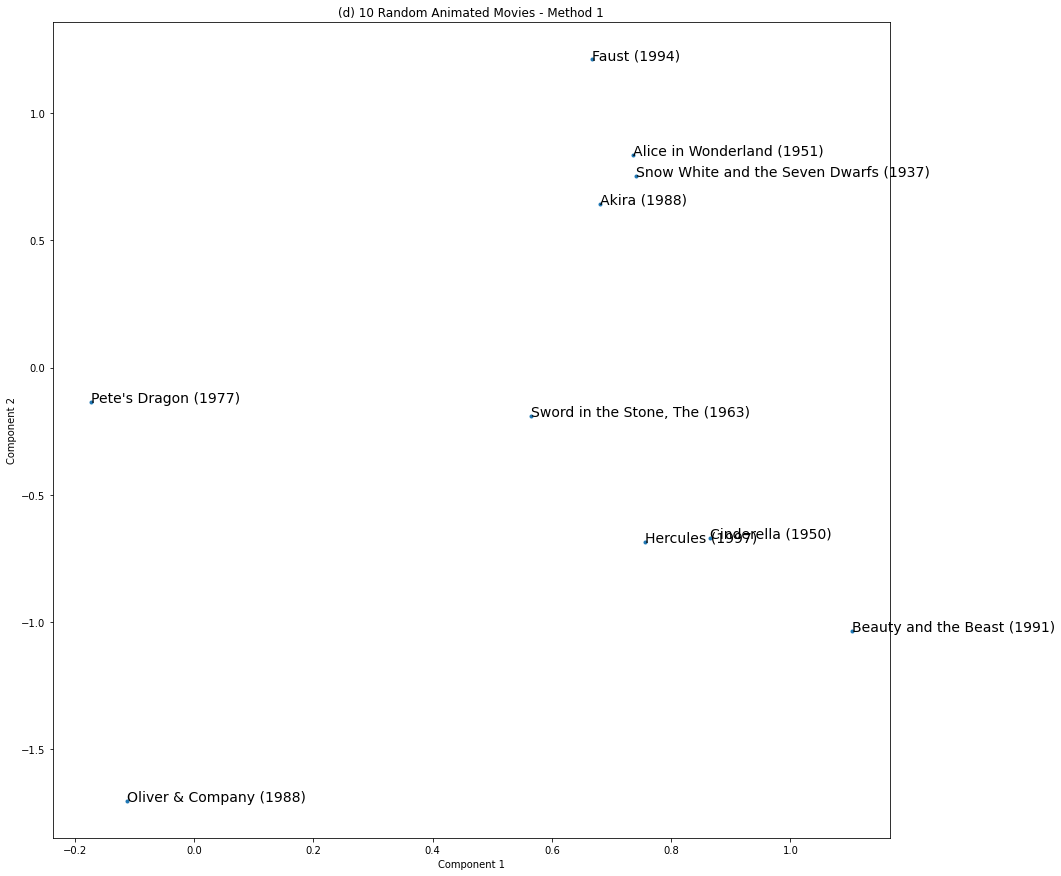

In [18]:
# 10 Random Animated Movies - Method 1
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in animatedmovies]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Animated Movies - Method 1")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

##With Bias (Question 3 - Method 2)

In [19]:
def grad_U_bias(Ui, Yij, Vj, ai, bj, reg, eta):
  return eta * ((reg * Ui) - (Vj * (Yij - np.dot(Ui, Vj) - ai - bj)))

def grad_V_bias(Vj, Yij, Ui, ai, bj, reg, eta):
  return eta * ((reg * Vj) - (Ui * (Yij - np.dot(Ui, Vj) - ai - bj)))

def grad_bias(Vj, Yij, Ui, ai, bj, eta):
  return -1 * eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def get_err_bias(U, V, Y, a, b, reg=0.0):
  err = 0
  for i in range(len(Y)):
    (i, j, Y_ij) = Y[i]
    err += 0.5 * pow(Y_ij - np.dot(U[i-1], V[j-1]) - a[i-1] - b[j-1], 2)
  left = (reg/2) * (pow(np.linalg.norm(U),2) + pow(np.linalg.norm(V),2))
  right = err
  return (left + right) / len(Y)


def train_model_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
  U = np.random.uniform(low = -0.5, high = 0.5, size = (M, K))
  V = np.random.uniform(low = -0.5, high = 0.5, size = (N, K))
  a = np.random.uniform(low = -0.5, high = 0.5, size = (M, ))
  b = np.random.uniform(low = -0.5, high = 0.5, size = (N, ))
  MSE_curr = get_err_bias(U, V, Y, a, b, reg)
  for k in range(max_epochs):
    np.random.shuffle(Y)
    for i, j, Y_ij in Y:
      U[i - 1] = U[i - 1] - grad_U_bias(U[i - 1], Y_ij, V[j - 1], a[i - 1], b[j - 1], reg, eta)
      V[j - 1] = V[j - 1] - grad_V_bias(V[j - 1], Y_ij, U[i - 1], a[i - 1], b[j - 1], reg, eta)
      bias_grad = grad_bias(U[i - 1], Y_ij, V[j - 1], a[i - 1], b[j - 1], eta)
      a[i - 1] -= bias_grad
      b[j - 1] -= bias_grad
    MSE = get_err_bias(U, V, Y, a, b, reg)
    print("Epoch %s: E_in = %s" %(k + 1, MSE))
    if k == 0:
      initial_loss = MSE_curr - MSE
    elif (MSE_curr - MSE)/(initial_loss) <= eps:
      break
    MSE_curr = MSE
  return U, V, a, b, MSE_curr

In [20]:
data = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv")
test = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv")

Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U_bias, V_bias, A, B, err = train_model_bias(M, N, K, eta, reg, Y_train)
E_in.append(err)
E_out.append(get_err_bias(U_bias, V_bias, Y_test, A, B, reg))
print("E_out = %s" %(E_out[0]))

Factorizing with  943  users,  1682  movies.
Epoch 1: E_in = 0.466942625887817
Epoch 2: E_in = 0.36337001398910534
Epoch 3: E_in = 0.3152910469699889
Epoch 4: E_in = 0.2836853683609236
Epoch 5: E_in = 0.261142606088612
Epoch 6: E_in = 0.24478236242050588
Epoch 7: E_in = 0.23149940121902549
Epoch 8: E_in = 0.22266297298241564
Epoch 9: E_in = 0.21466095815066885
Epoch 10: E_in = 0.20874316280177882
Epoch 11: E_in = 0.2030287487814973
Epoch 12: E_in = 0.19907400661516242
Epoch 13: E_in = 0.19591492299510324
Epoch 14: E_in = 0.1929041662358657
Epoch 15: E_in = 0.19130416639219003
Epoch 16: E_in = 0.1887366128131173
Epoch 17: E_in = 0.18769795464420996
Epoch 18: E_in = 0.1857639783463354
Epoch 19: E_in = 0.18425191858114856
Epoch 20: E_in = 0.18405148649391959
E_out = 0.6486884975244125


In [21]:
A_bias = np.linalg.svd(V_bias.transpose())[0]
V_tilde_bias = np.dot(A_bias[:, :2].transpose(), V_bias.transpose())
U_tilde_bias = np.dot(A_bias[:, :2].transpose(), U_bias.transpose())

for i in range(len(V_tilde)):
  V_tilde_bias[i] -= np.mean(V_tilde_bias[i])
  V_tilde_bias[i] /= np.std(V_tilde_bias[i])
  U_tilde_bias[i] -= np.mean(V_tilde_bias[i])
  U_tilde_bias[i] /= np.std(V_tilde_bias[i])

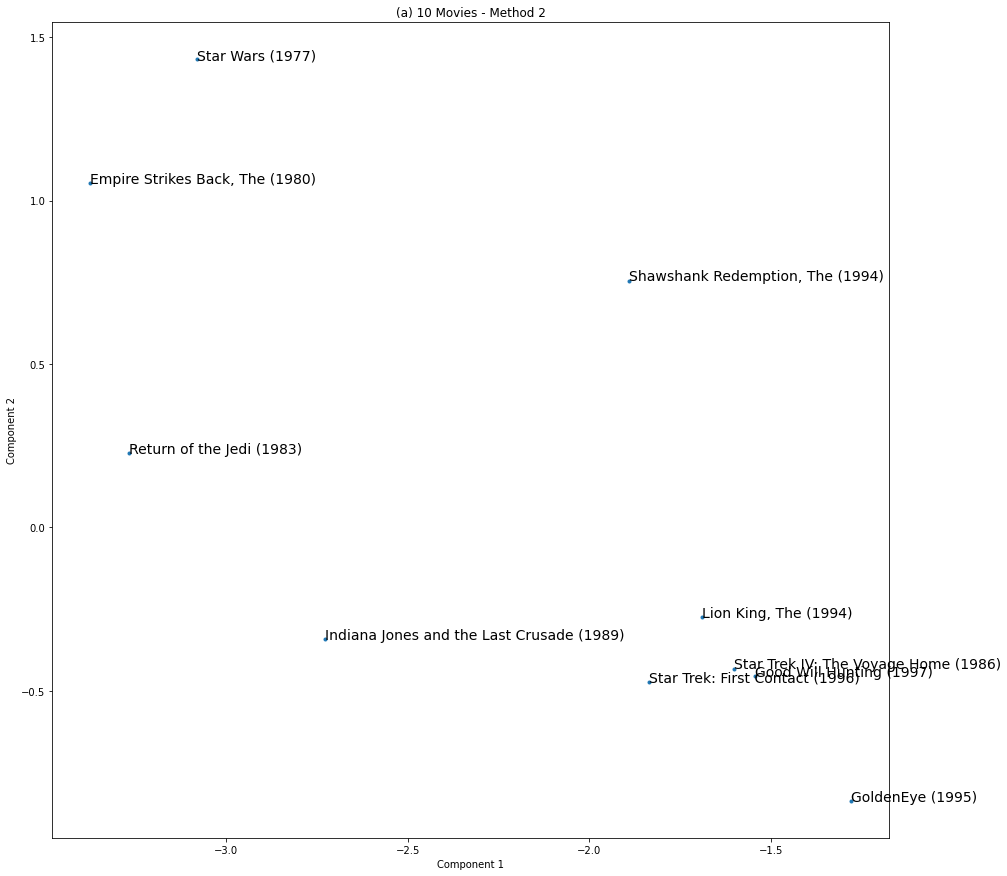

In [22]:
# Any ten movies of our choice
movie_names = np.array(movies)[:,1]
movie_indices = np.array([1, 49, 63, 70, 171, 180, 209, 221, 229, 271])
movie_coordinates = V_tilde_bias[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("(a) 10 Movies - Method 2")
for i, t in enumerate(movie_labels):
  plt.annotate(t, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

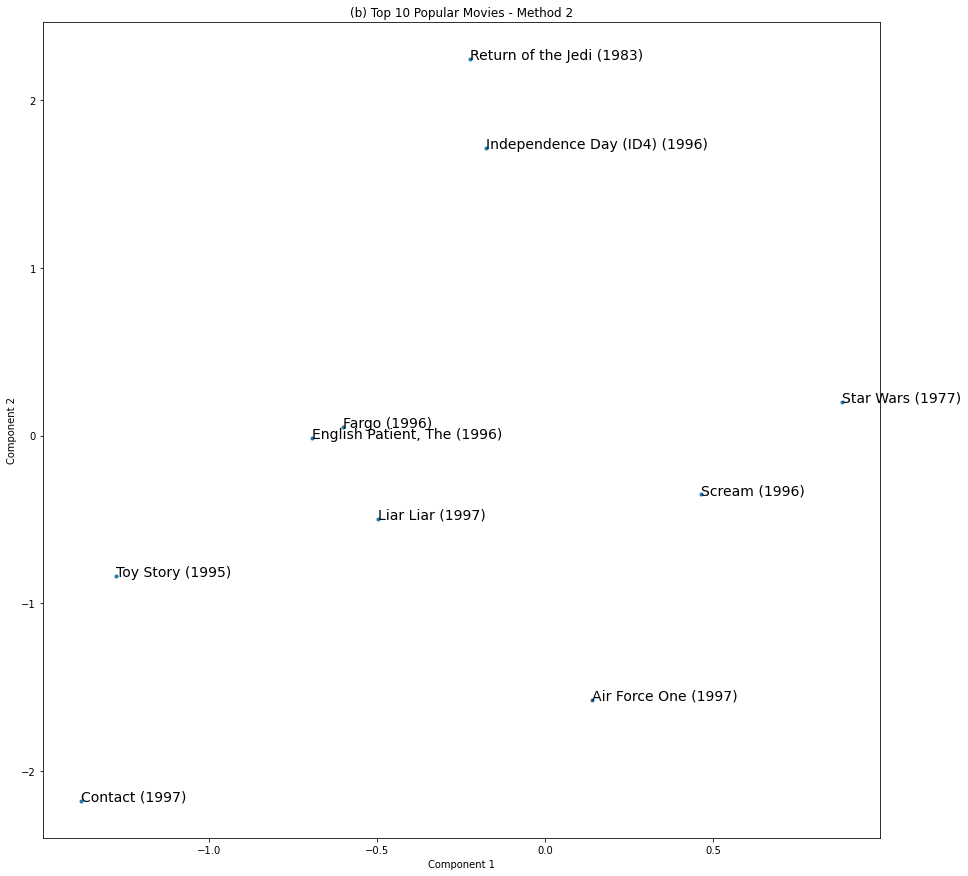

In [23]:
# 10 most popular movies (by most ratings) - Method 2
top10popular = np.array(data["Movie ID"].value_counts().nlargest(10).index)

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10popular]
movie_coordinates = V_tilde_bias[:, top10popular]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(b) Top 10 Popular Movies - Method 2")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

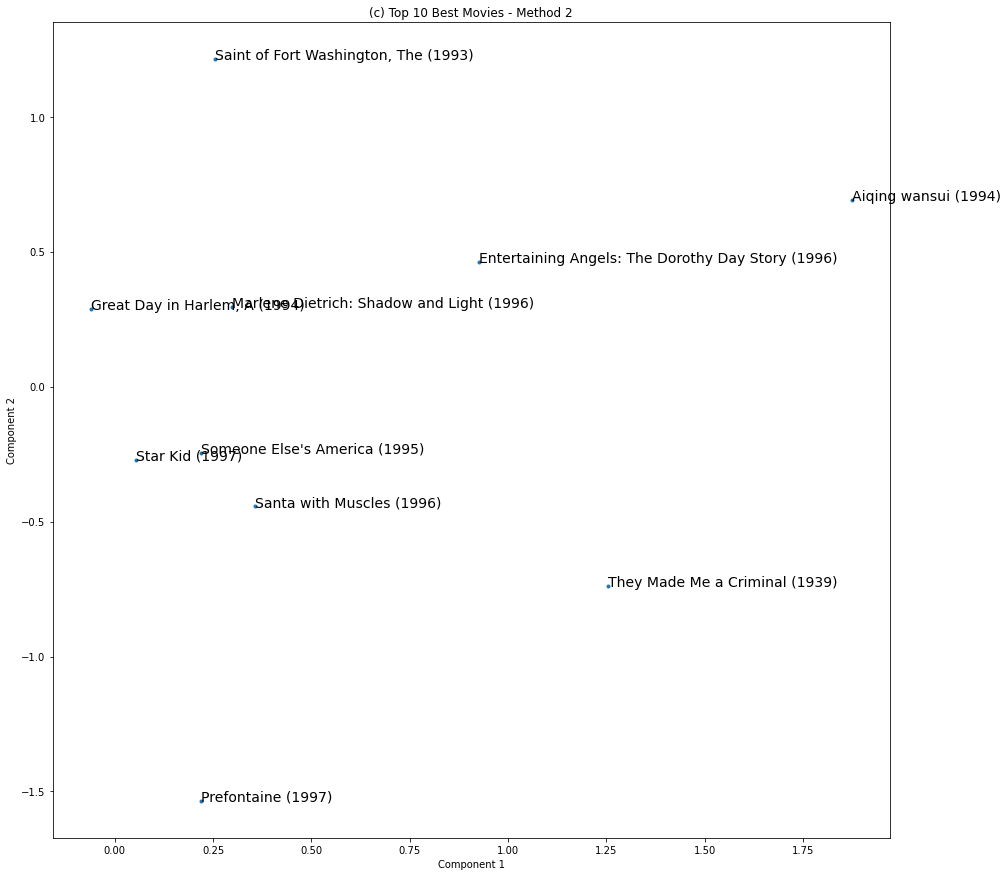

In [24]:
# 10 best movies (by highest average ratings) - Method 2
top10best = data.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10best]
movie_coordinates = V_tilde_bias[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(c) Top 10 Best Movies - Method 2")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

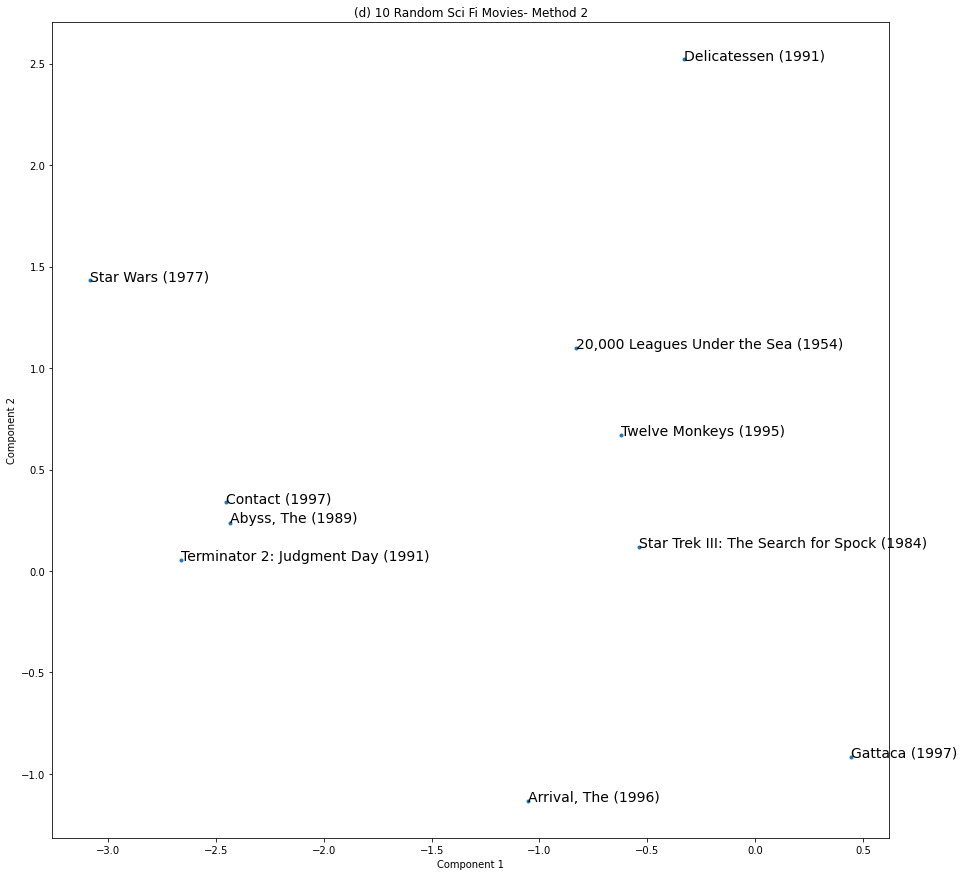

In [25]:
# 10 Random Sci Movies - Method 2
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in scifimovies]
movie_coordinates = V_tilde_bias[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Sci Fi Movies- Method 2")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

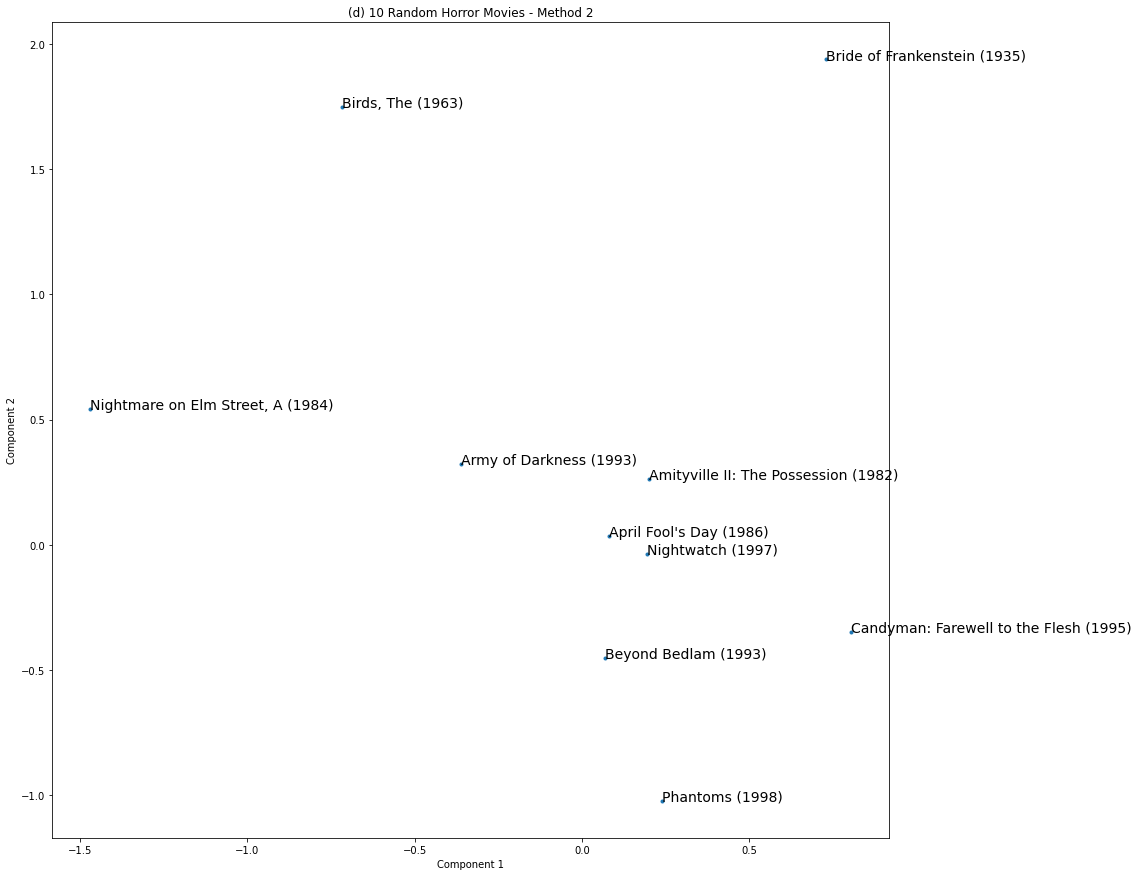

In [26]:
# 10 Random Horror Movies - Method 2
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in horrormovies]
movie_coordinates = V_tilde_bias[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Horror Movies - Method 2")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

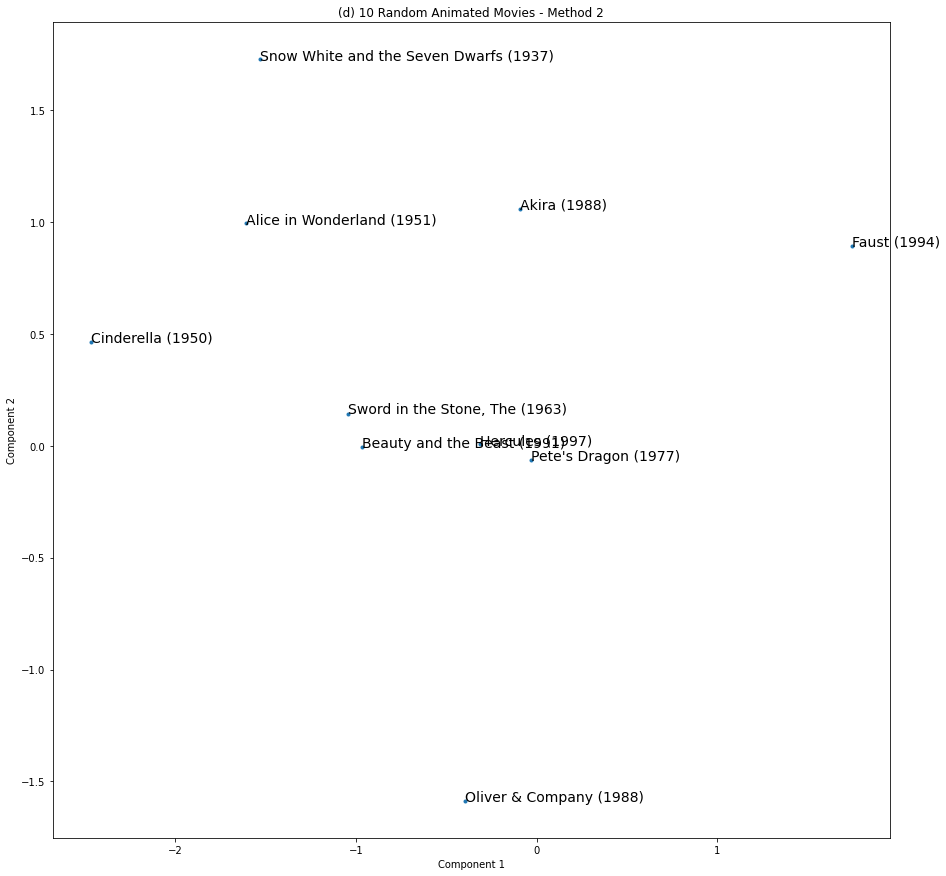

In [27]:
# 10 Random Animated Movies - Method 2
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in animatedmovies]
movie_coordinates = V_tilde_bias[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Animated Movies - Method 2")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

##Off-The-Shelf (Question 3 - Method 3)

In [28]:
!pip install surprise

In [36]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

reader = Reader()
trainset = Dataset.load_from_df(train, reader)

algo = SVD()

trainset = trainset.build_full_trainset()
algo.fit(trainset)
V_tilde_shelf = algo.qi.T

In [51]:
from surprise import accuracy

testset = [test.loc[i].to_list() for i in range(len(test))]
predictions = algo.test(testset)

accuracy.mse(predictions)

MSE: 0.8566


0.8565679962375647

In [60]:
dataset = Dataset.load_from_df(data, reader)
algo = SVD()
cross_validate(algo, dataset, measures=['MSE'], cv=5, verbose=True)

Evaluating MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.8637  0.8899  0.8850  0.8707  0.8720  0.8763  0.0097  
Fit time          4.88    4.96    4.89    4.92    4.94    4.92    0.03    
Test time         0.15    0.16    0.14    0.26    0.17    0.18    0.04    


{'fit_time': (4.882451295852661,
  4.959321022033691,
  4.894299745559692,
  4.9173424243927,
  4.936379671096802),
 'test_mse': array([0.86371072, 0.88985482, 0.88499186, 0.87073672, 0.8720248 ]),
 'test_time': (0.14658093452453613,
  0.1621706485748291,
  0.1410684585571289,
  0.2605094909667969,
  0.16859698295593262)}

In [61]:
algo = SVD()
cross_validate(algo, dataset, measures=['MSE'], cv=10, verbose=True)

Evaluating MSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MSE (testset)     0.8618  0.8653  0.8634  0.8470  0.8661  0.8532  0.8477  0.8744  0.8814  0.8719  0.8632  0.0107  
Fit time          6.74    5.60    5.59    5.60    5.61    5.60    5.55    5.56    5.57    5.54    5.70    0.35    
Test time         0.07    0.16    0.08    0.07    0.09    0.18    0.08    0.07    0.07    0.17    0.10    0.04    


{'fit_time': (6.740260362625122,
  5.600190877914429,
  5.593852281570435,
  5.597395420074463,
  5.605553865432739,
  5.600281476974487,
  5.546165227890015,
  5.55863618850708,
  5.570153474807739,
  5.54167366027832),
 'test_mse': array([0.86184634, 0.86528207, 0.86336728, 0.84697002, 0.86608136,
        0.85323862, 0.84772055, 0.87438007, 0.88138026, 0.87185891]),
 'test_time': (0.07211804389953613,
  0.16474223136901855,
  0.08019161224365234,
  0.07384777069091797,
  0.08651399612426758,
  0.18329501152038574,
  0.08082365989685059,
  0.06955432891845703,
  0.07133984565734863,
  0.1674814224243164)}

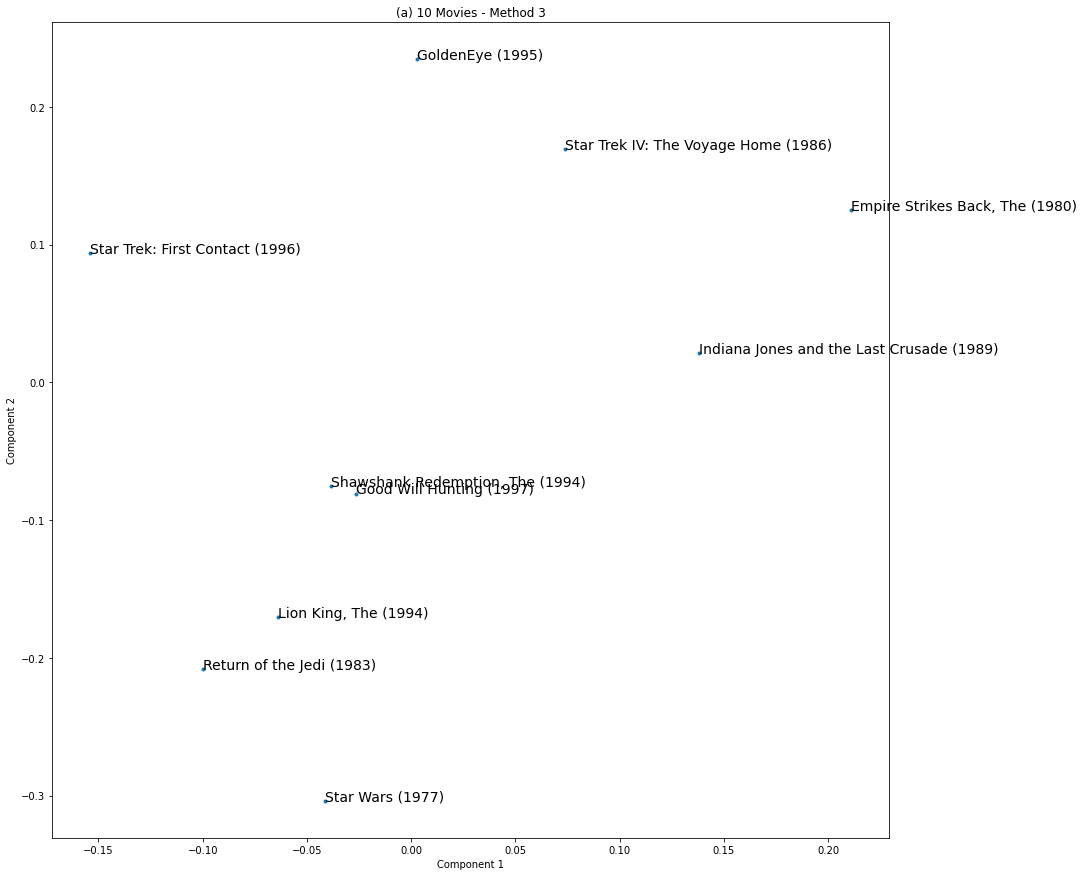

In [37]:
# Any ten movies of our choice
movie_names = np.array(movies)[:,1]
movie_indices = np.array([1, 49, 63, 70, 171, 180, 209, 221, 229, 271])
movie_coordinates = V_tilde_shelf[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("(a) 10 Movies - Method 3")
for i, t in enumerate(movie_labels):
  plt.annotate(t, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

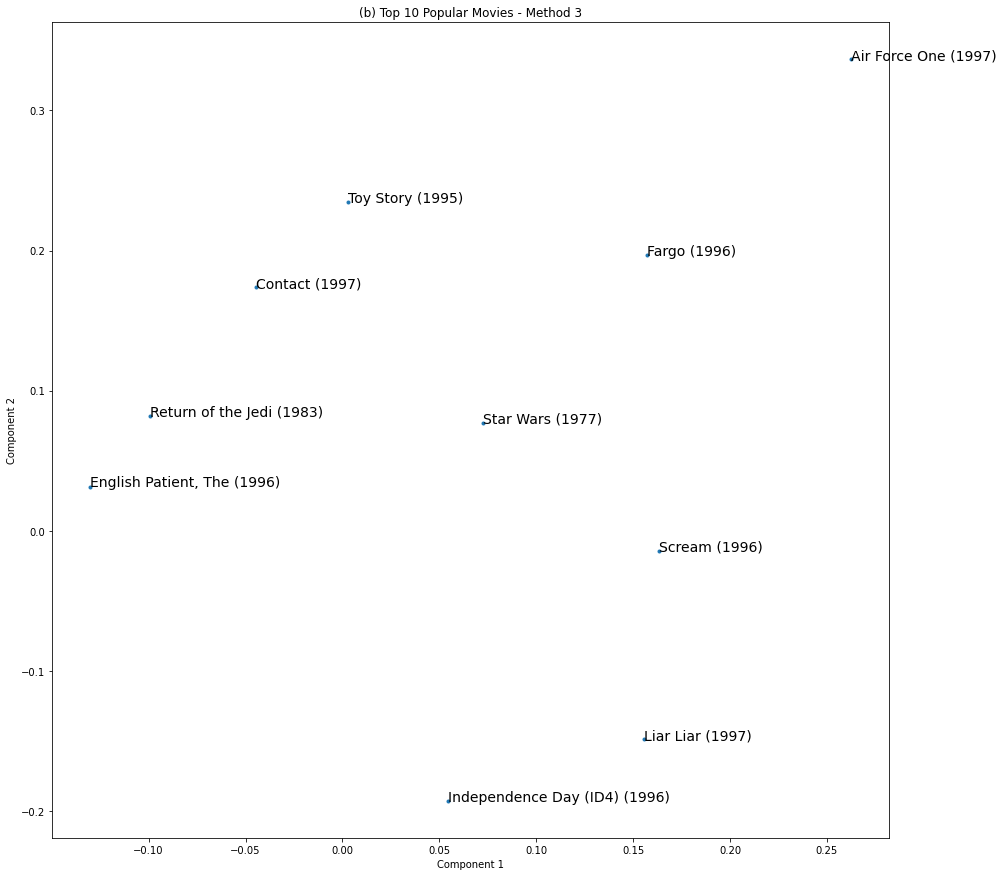

In [38]:
# 10 most popular movies (by most ratings) - Method 3
top10popular = np.array(data["Movie ID"].value_counts().nlargest(10).index)

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10popular]
movie_coordinates = V_tilde_shelf[:, top10popular]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(b) Top 10 Popular Movies - Method 3")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

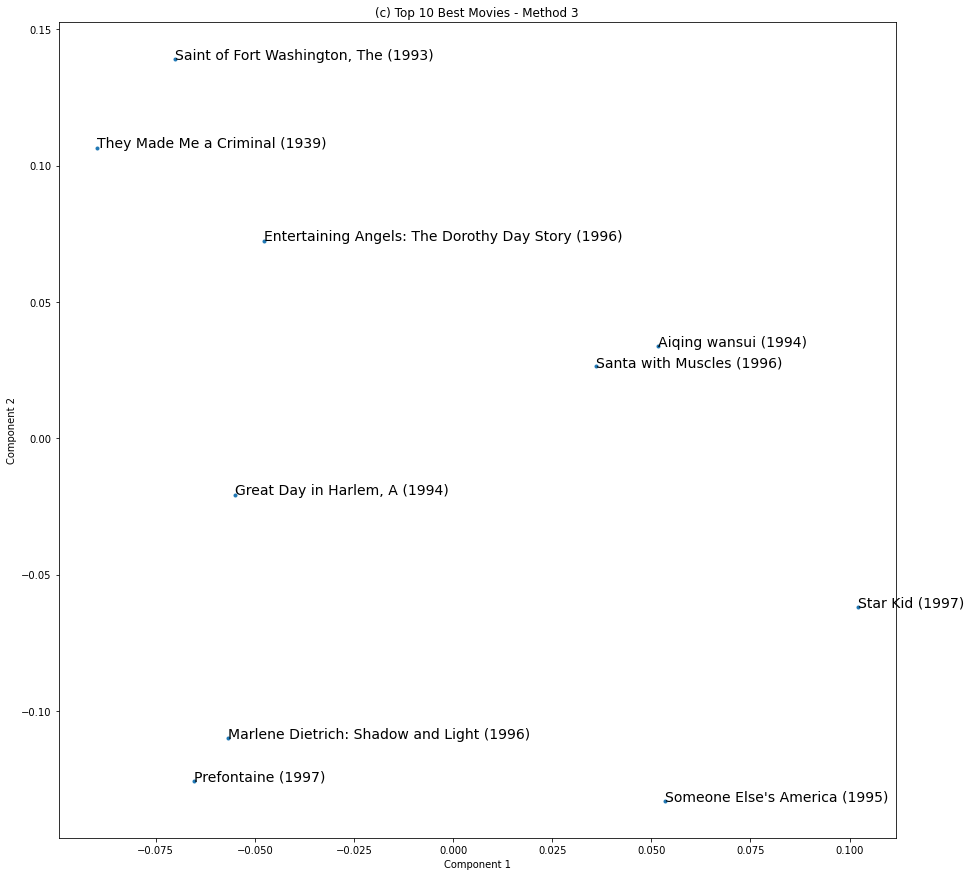

In [39]:
# 10 best movies (by highest average ratings) - Method 3
top10best = data.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index

movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in top10best]
movie_coordinates = V_tilde_shelf[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(c) Top 10 Best Movies - Method 3")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

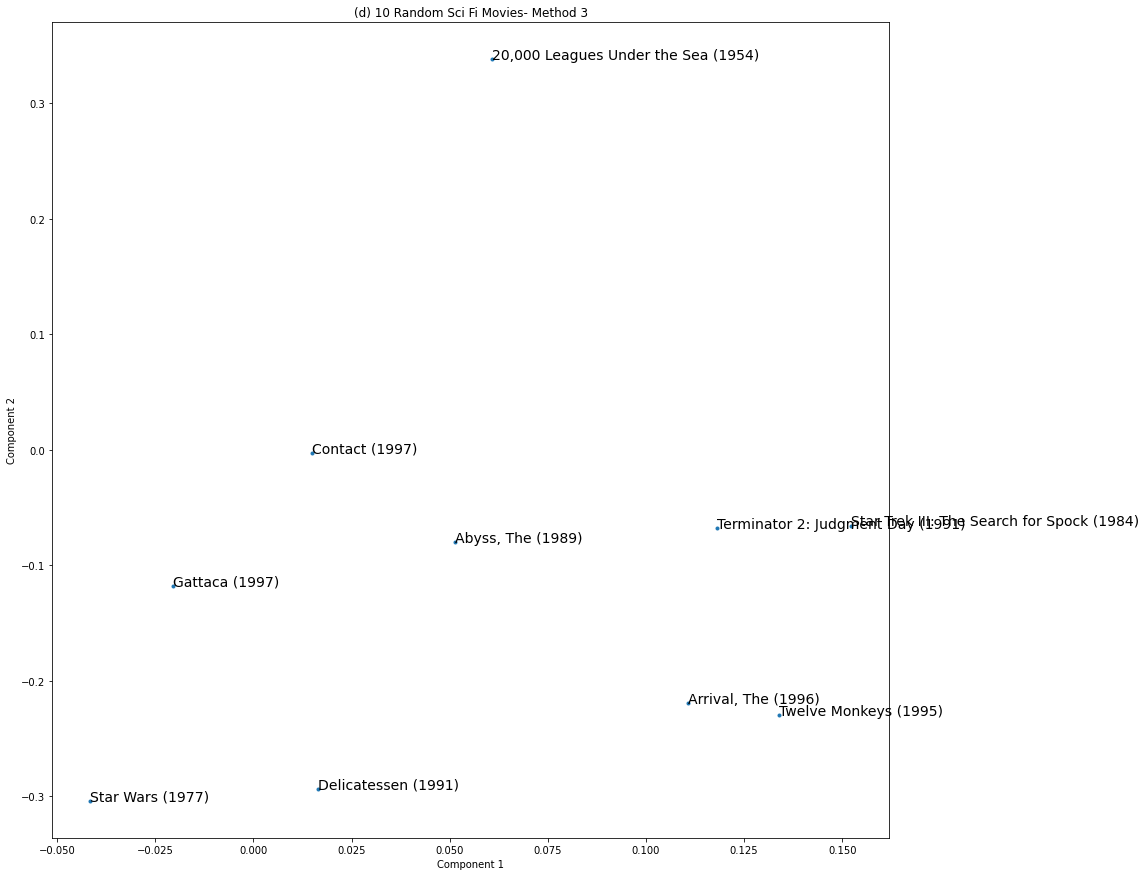

In [40]:
# 10 Random Sci Movies - Method 3
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in scifimovies]
movie_coordinates = V_tilde_shelf[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Sci Fi Movies- Method 3")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

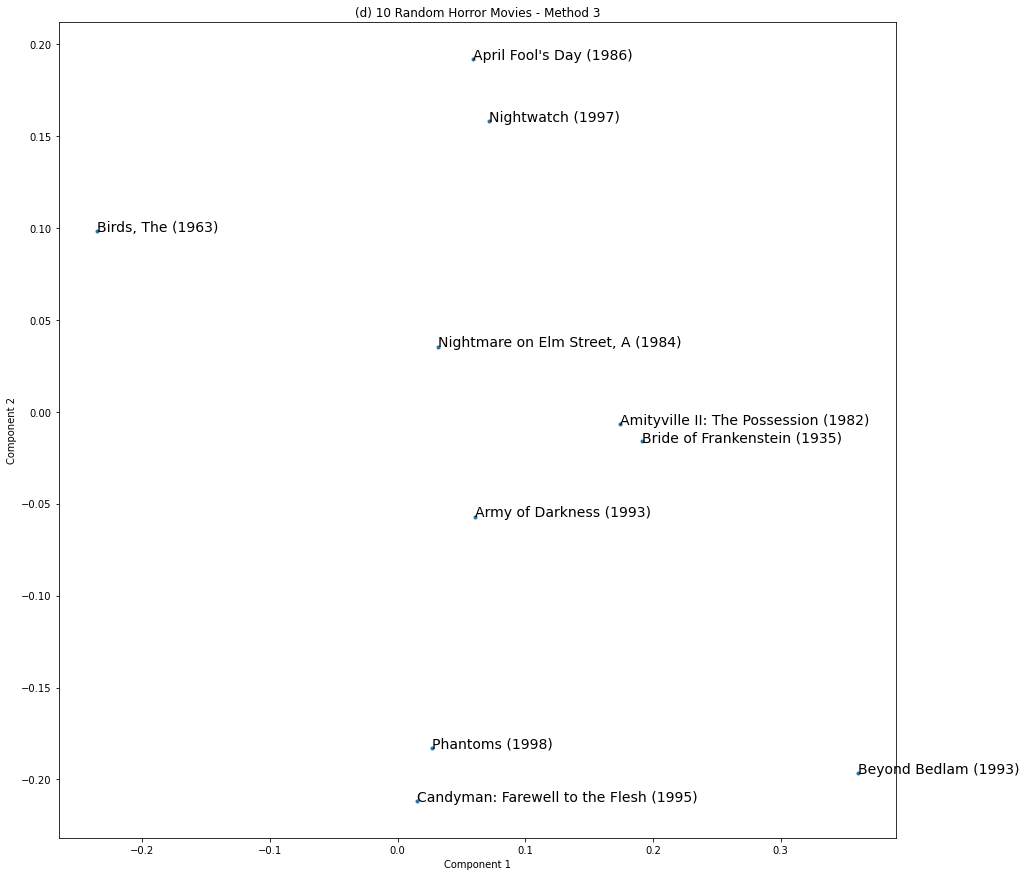

In [41]:
# 10 Random Horror Movies - Method 3
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in horrormovies]
movie_coordinates = V_tilde_shelf[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Horror Movies - Method 3")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()

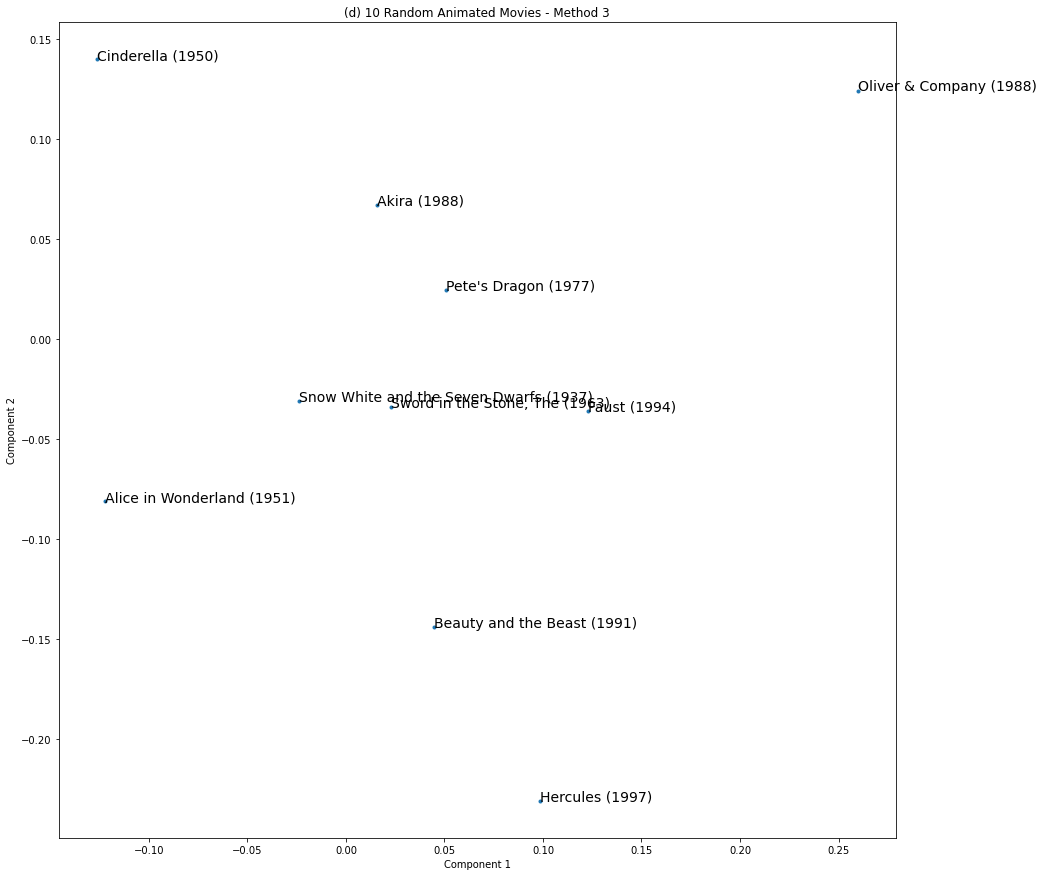

In [42]:
# 10 Random Animated Movies - Method 3
movie_names = np.array(movies)[:,1]
movie_indices = [idx - 1 for idx in animatedmovies]
movie_coordinates = V_tilde_shelf[:, movie_indices]
movie_labels = movie_names[movie_indices]
plt.figure(figsize=(15,15))
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.plot(movie_coordinates[0], movie_coordinates[1], '.')
plt.title("(d) 10 Random Animated Movies - Method 3")
for i, label in enumerate(movie_labels):
  plt.annotate(label, (movie_coordinates[0, i], movie_coordinates[1, i]), fontsize = 14)
plt.show()